In [75]:
import json
import os
import sys

sys.path.append('../')
sys.path.append('../../')
sys.path.append('../../../')
sys.path.append('../../src')
sys.path.append('../../prompts')
sys.path.append('../../src/llmperf')

# Run multiple models through the benchmarking process

In [89]:
# results_dir = '../data/results/tracking_tests'
results_dir = '../../data/bundle_tests/aa_tests/20260113-110355.785523'

# Analyze metrics through models

In [90]:
import pandas as pd

from benchmarking.utils import read_perf_eval_json_files

## Read the input json file

In [91]:
df = read_perf_eval_json_files(results_dir, type='summary')
df = df.set_index(['num_input_tokens','num_output_tokens','num_concurrent_requests'])
df.head(10)

name  \
num_input_tokens num_output_tokens num_concurrent_requests                                                      
3900             100               16                       synthetic_0_Meta-Llama-3-1-8B-Instruct_3900_10...   
                                   5                        synthetic_0_Meta-Llama-3-1-8B-Instruct_3900_10...   
8000             100               1                        synthetic_0_gpt-oss-120b_8000_100_1_stream_7f2...   
3900             100               9                        synthetic_0_Meta-Llama-3-1-8B-Instruct_3900_10...   
8000             100               3                        synthetic_0_Meta-Llama-3-1-8B-Instruct_8000_10...   
16000            100               1                        synthetic_0_Llama-4-Maverick-17B-128E-Instruct...   
8000             100               3                        synthetic_0_Meta-Llama-3-1-8B-Instruct_8000_10...   
                                   16                       synthetic_0_Meta-Llama-3-1-8B-Instruct_8000_10...   
16000            100               5                        synthetic_0_Meta-Llama-3-1-8B-Instruct_16000_1...   
32000            100               1                        synthetic_0_gpt-oss-120b_32000_100_1_stream_c0...   

                                                                                         model  \
num_input_tokens num_output_tokens num_concurrent_requests                                       
3900             100               16                               Meta-Llama-3.1-8B-Instruct   
                                   5                                Meta-Llama-3.1-8B-Instruct   
8000             100               1                                              gpt-oss-120b   
3900             100               9                                Meta-Llama-3.1-8B-Instruct   
8000             100               3                                Meta-Llama-3.1-8B-Instruct   
16000            100               1                        Llama-4-Maverick-17B-128E-Instruct   
8000             100               3                                Meta-Llama-3.1-8B-Instruct   
                                   16                               Meta-Llama-3.1-8B-Instruct   
16000            100               5                                Meta-Llama-3.1-8B-Instruct   
32000            100               1                                              gpt-oss-120b   

                                                            client_ttft_s_p5  \
num_input_tokens num_output_tokens num_concurrent_requests                     
3900             100               16                                 0.9505   
                                   5                                  1.1217   
8000             100               1                                  1.2130   
3900             100               9                                  0.9419   
8000             100               3                                  1.1152   
16000            100               1                                  2.3729   
8000             100               3                                  1.0335   
                                   16                                 3.5002   
16000            100               5                                  2.3377   
32000            100               1                                  3.0949   

                                                            client_ttft_s_p25  \
num_input_tokens num_output_tokens num_concurrent_requests                      
3900             100               16                                  2.3556   
                                   5                                   1.1218   
8000             100               1                                   1.2220   
3900             100               9                                   1.7279   
8000             100               3                                   1.3820   
16000            100               1       

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_benchmarking_data(df, ycol, ylabel):
    df = df.reset_index()
    # Create a new column combining 'in' and 'out' into a single legend label
    df['in_out'] = df.apply(lambda row: f"({row['num_input_tokens']}, {row['num_output_tokens']})", axis=1)

    plt.figure(figsize=(8, 5))
    
    # Plot main performance metric
    sns.lineplot(data=df, x='num_concurrent_requests', y=ycol, hue='in_out', marker='o', linewidth=2)
    
    # Plot client_output_token_per_sec as a dashed line
    if ycol=='output_token_per_s_p50' and 'client_output_token_per_s_p50' in df.columns:
        sns.lineplot(data=df, x='num_concurrent_requests', y='client_output_token_per_s_p50', hue='in_out', 
                     marker='o', linestyle='dashed', alpha=0.6)
    
    # Set x-axis to log2 scale
    plt.xscale("log", base=2)
    
    # Customize x-axis ticks to show real numbers instead of 2^n notation
    xticks = sorted(df['num_concurrent_requests'].unique())
    plt.xticks(xticks, labels=[str(x) for x in xticks])
    
    # Labels and title
    plt.xlabel("Concurrency [log2 scale]")
    plt.ylabel(ylabel)
    if ycol=='output_token_per_s_p50':
        plt.title("Performance for Different (in, out) Token Combinations\n(Solid = Server, Dashed = Client)")
    else:
        plt.title("Performance for Different (in, out) Token Combinations")
    
    plt.legend(title="(in, out)", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, which="both", linestyle="--")
    
    plt.show();

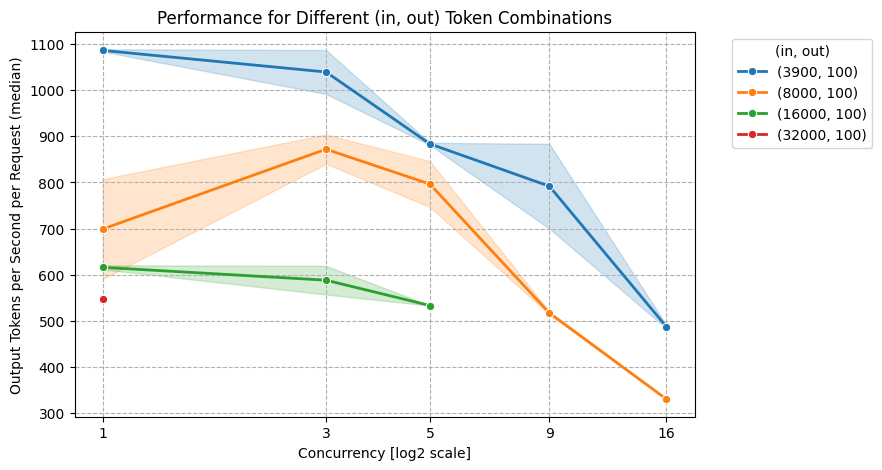

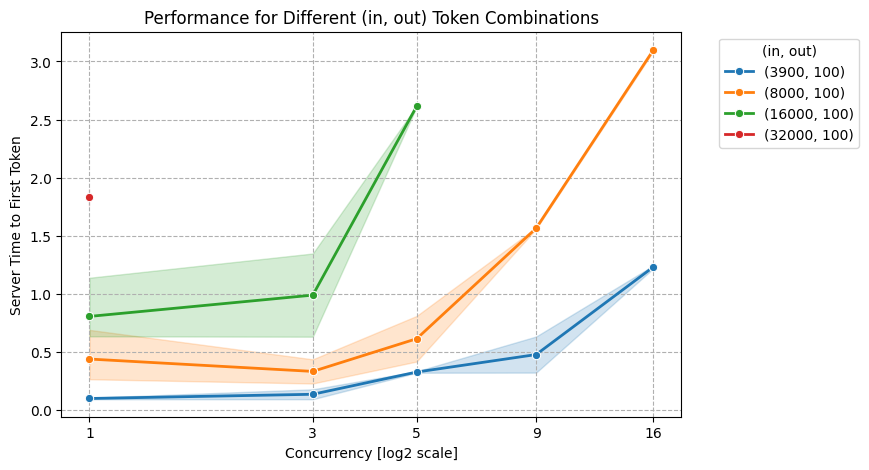

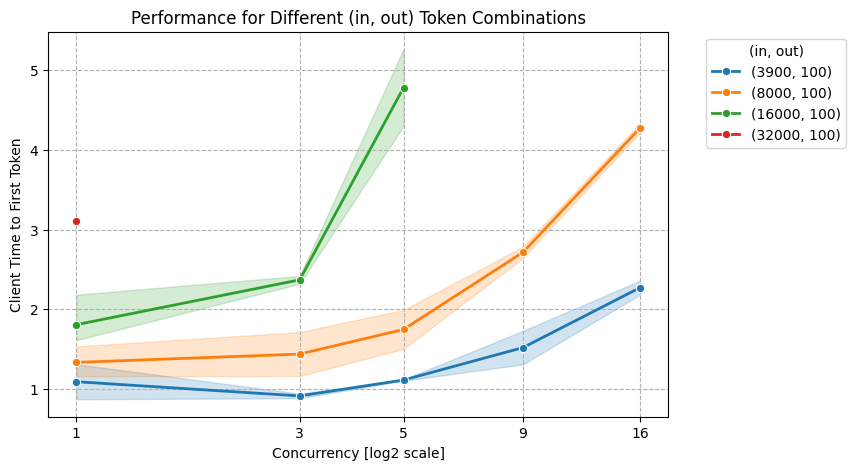

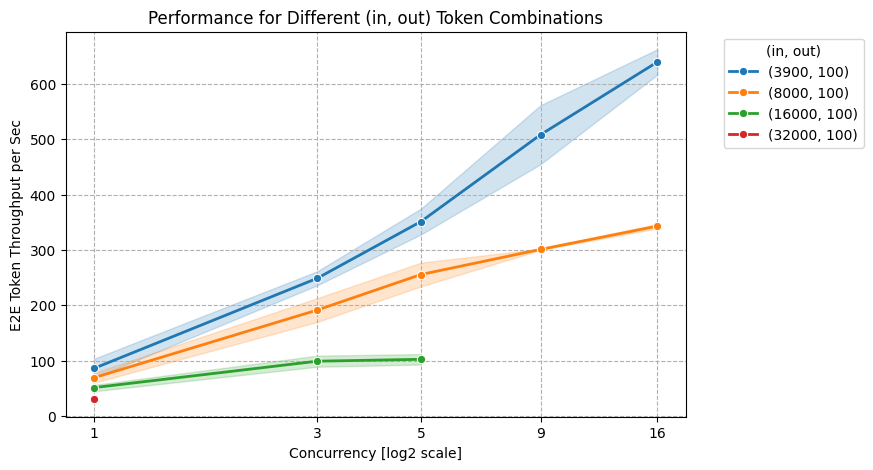

In [93]:
plot_benchmarking_data(df, 'server_output_token_per_s_p50', 'Output Tokens per Second per Request (median)')
plot_benchmarking_data(df, 'server_ttft_s_p50', 'Server Time to First Token')
plot_benchmarking_data(df, 'client_ttft_s_p50', 'Client Time to First Token')
plot_benchmarking_data(df, 'client_total_output_throughput', 'E2E Token Throughput per Sec')


# Analyze switching time

__Note:__ This analysis will work if a Bundle endpoint is used. Users will be able to test and compare performance metrics for different experts.

In [94]:
from synthetic_performance_eval_script import load_requests_with_switching
from benchmarking.utils import read_perf_eval_json_files


df_requests = load_requests_with_switching(
    output_files_dir=results_dir,
    read_perf_eval_json_files_fn=read_perf_eval_json_files,
)

# get model name 
df_requests['model'] = df_requests['filename'].apply(lambda x: x.split('_')[2])

cols = [
    "uuid",
    "model",
    "server_number_input_tokens",
    "server_number_output_tokens",
    "start_time",
    "server_ttft_s",
    "requests_batching_per_request",
    "switching_time",
]

df_switching_per_request = df_requests[cols].sort_values("start_time")
df_switching_per_request

,uuid,model,server_number_input_tokens,server_number_output_tokens,start_time,server_ttft_s,requests_batching_per_request,switching_time
367,8f5e5810-ed86-4c4a-b9ef-16833d014f7a,Meta-Llama-3-1-8B-Instruct,3934,100,11:03:57.256449,0.105939,1,0.000000
276,6a113e56-2a84-4813-9277-5a30bc4d4948,Meta-Llama-3-1-8B-Instruct,3934,100,11:03:59.686383,0.093277,1,0.000000
275,6a113e56-2a84-4813-9277-5a30bc4d4948,Meta-Llama-3-1-8B-Instruct,3934,100,11:03:59.686637,0.178397,2,0.000000
274,6a113e56-2a84-4813-9277-5a30bc4d4948,Meta-Llama-3-1-8B-Instruct,3934,100,11:03:59.686787,0.178397,2,0.000000
405,cd040b6d-b337-400c-95d5-de2bdf384515,Meta-Llama-3-1-8B-Instruct,3934,100,11:04:01.807721,0.095419,1,0.000000
...,...,...,...,...,...,...,...,...
371,c4def99f-8787-4d3c-95cd-a72d01613b50,Llama-4-Maverick-17B-128E-Instruct,16011,101,11:08:04.613697,1.306950,1,0.662615
372,c4def99f-8787-4d3c-95cd-a72d01613b50,Llama-4-Maverick-17B-128E-Instruct,16011,101,11:08:07.078335,0.647335,1,0.662615
373,c4def99f-8787-4d3c-95cd-a72d01613b50,Llama-4-Maverick-17B-128E-Instruct,16011,101,11:08:08.862683,0.645437,1,0.662615
374,c4def99f-8787-4d3c-95cd-a72d01613b50,Llama-4-Maverick-17B-128E-Instruct,16011,101,11:08:10.653025,0.645710,1,0.662615


In [95]:
import os
import pandas as pd
import plotly.express as px
from typing import Optional


def _parse_start_time(df: pd.DataFrame, col: str = "start_time") -> pd.Series:
    """
    Robust parsing for start_time provided as string.
    Supports:
      - ISO timestamps
      - Datetime-like strings
      - Epoch seconds (as string)
    """
    # Try datetime parsing first
    parsed = pd.to_datetime(df[col], errors="coerce", utc=True)

    if parsed.isna().all():
        # Fallback: epoch seconds as string
        try:
            parsed = pd.to_datetime(
                df[col].astype(float),
                unit="s",
                utc=True,
            )
        except Exception as e:
            raise ValueError(
                f"Unable to parse '{col}' as datetime or epoch seconds"
            ) from e

    if parsed.isna().any():
        raise ValueError(
            f"Some values in '{col}' could not be parsed. "
            "Please check the input format."
        )

    return parsed


def plot_ttft_switching_scatter(
    df_requests: pd.DataFrame,
    save_html: bool = False,
    output_path: Optional[str] = None,
    title: str = "TTFT vs Request Start Time (Switching Effects)",
):
    """
    Interactive Plotly scatter plot:
      - x: request start time (relative, seconds)
      - y: server TTFT
      - color: model + sequence size
      - symbol: batch size

    Handles start_time provided as string.
    """

    if df_requests.empty:
        raise ValueError("df_requests is empty")

    df = df_requests.copy()

    # --------------------------------------------------
    # Parse start_time safely (string -> datetime)
    # --------------------------------------------------
    df["_start_dt"] = _parse_start_time(df, "start_time")

    t0 = df["_start_dt"].min()
    df["start_time_rel_s"] = (df["_start_dt"] - t0).dt.total_seconds()

    # --------------------------------------------------
    # Derived visualization fields
    # --------------------------------------------------
    df["sequence"] = (
        df["server_number_input_tokens"].astype(str)
        + "→"
        + df["server_number_output_tokens"].astype(str)
    )

    df["model_sequence"] = df["model"] + " | " + df["sequence"]

    # --------------------------------------------------
    # Plotly scatter
    # --------------------------------------------------
    fig = px.scatter(
        df,
        x="start_time_rel_s",
        y="server_ttft_s",
        color="model_sequence",
        symbol="requests_batching_per_request",
        title=title,
        labels={
            "start_time_rel_s": "Request start time (relative, s)",
            "server_ttft_s": "Server TTFT (s)",
            "model_sequence": "Model | Sequence",
            "requests_batching_per_request": "Batch size",
        },
        hover_data={
            "uuid": True,
            "model": True,
            "sequence": True,
            "requests_batching_per_request": True,
            "switching_time": True,
            "start_time": True,  # original string preserved
        },
    )

    fig.update_traces(marker=dict(size=8, opacity=0.75))
    fig.update_layout(
        template="plotly_white",
        height=600,
        legend_title_text="Model | Sequence",
    )

    # --------------------------------------------------
    # Optional HTML export
    # --------------------------------------------------
    if save_html:
        if not output_path:
            raise ValueError("output_path must be provided when save_html=True")

        output_path = os.path.expanduser(output_path)
        os.makedirs(os.path.dirname(output_path), exist_ok=True)

        fig.write_html(
            output_path,
            full_html=True,
            include_plotlyjs="cdn",
        )

        print(f"✅ Plot saved to {output_path}")

    return fig


In [96]:
fig = plot_ttft_switching_scatter(
    df_requests,
    save_html=True,
    output_path="./ttft_switching_analysis.html",
)

fig

✅ Plot saved to ./ttft_switching_analysis.html


In [97]:
# consolidation file path
parent_dir = os.path.dirname(results_dir)
run_name = os.path.basename(results_dir)
consolidation_file = os.path.join(parent_dir, f'consolidated_results/{run_name}.xlsx')

In [98]:
import pandas as pd
import plotly.express as px

# Load data
df = pd.read_excel(consolidation_file)

# Select and rename columns
plot_df = df[
    [
        "model",
        "num_input_tokens",
        "representative_batch_size",
        "switching_time",
        "server_ttft_s_mean",
        "server_output_token_per_s_mean",
    ]
].rename(
    columns={
        "num_input_tokens": "sequence_size",
        "representative_batch_size": "batch_size",
        "server_ttft_s_mean": "ttft_s",
        "server_output_token_per_s_mean": "output_throughput",
    }
)

# Convert to long format
long_df = plot_df.melt(
    id_vars=["model", "sequence_size", "batch_size"],
    value_vars=["switching_time", "ttft_s", "output_throughput"],
    var_name="metric",
    value_name="value",
)

# Human-friendly metric names (order matters for facet columns)
metric_labels = {
    "switching_time": "Switching Time (s)",
    "ttft_s": "TTFT (s)",
    "output_throughput": "Output Throughput (tokens/s)",
}
long_df["metric"] = long_df["metric"].map(metric_labels)

# Plot
fig = px.scatter(
    long_df,
    x="sequence_size",
    y="value",
    color="sequence_size",
    facet_row="model",
    facet_col="metric",
    hover_data=["batch_size"],
    title="Switching Time, TTFT, and Output Throughput per Model",
)

# Layout tuning
fig.update_layout(
    height=300 * long_df["model"].nunique(),
    legend_title="Sequence size",
)

# X axis title (shared meaning)
fig.for_each_xaxis(lambda x: x.update(title="Sequence size"))

# Y axis titles per facet column
fig.update_yaxes(title_text="Switching Time (s)", col=1)
fig.update_yaxes(title_text="TTFT (s)", col=2)
fig.update_yaxes(title_text="Output Throughput (tokens/s)", col=3)

fig.show()
